# Hybrid Modelling of HUMINT Source Performance: ML-TSSP Model

This notebook walks through the **entire HUMINT ML-TSSP pipeline** as implemented in the project: data generation/preprocessing, classification (XGBoost + SMOTE), regression (GRU for reliability/deception), TSSP optimization, cost analysis, and advanced metrics (EVPI, EMV, sensitivity, efficiency frontier).

Run from **project root** so `src` and config resolve correctly. GLPK (or CBC) must be installed for TSSP and advanced metrics.

## 1. Title and Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path (run notebook from project root). Matches src/pipeline.py logic.
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import joblib

from src.data import (
    generate_humint_dataset,
    prepare_classification_data,
    prepare_regression_data,
    scale_features,
    load_features_from_file,
)
from src.ml import ClassificationModelTrainer, RegressionModelTrainer
from src.optimization import TSSPModel
from src.analysis import (
    analyze_costs,
    generate_cost_report,
)
from src.analysis.advanced_metrics import (
    calculate_evpi,
    calculate_emv,
    sensitivity_analysis,
    generate_advanced_metrics_report,
    calculate_efficiency_frontier,
    plot_efficiency_frontier,
)
from src.utils.config import (
    PROJECT_ROOT as CONFIG_ROOT,
    MODELS_DIR,
    OUTPUT_DIR,
    BEHAVIOR_CLASSES,
    RECOURSE_COSTS,
    CLASSIFICATION_FEATURES_FILE,
    REGRESSION_FEATURES_FILE,
)
# Use config paths; config PROJECT_ROOT is parent of src/
PROJECT_ROOT = CONFIG_ROOT
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"Project root: {PROJECT_ROOT}")
print(f"Models dir: {MODELS_DIR}")
print(f"Output dir: {OUTPUT_DIR}")

Project root: D:\Updated-FINAL DASH
Models dir: D:\Updated-FINAL DASH\models
Output dir: D:\Updated-FINAL DASH\output


## 2. Data — Load or Generate Synthetic HUMINT Dataset

In [2]:
DATA_PATH = PROJECT_ROOT / "humint_source_dataset_15000_enhanced.csv"
if DATA_PATH.exists():
    print(f"Loading dataset from: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
else:
    print(f"Generating new dataset with 15000 sources...")
    df = generate_humint_dataset(
        n_sources=15000,
        random_seed=RANDOM_SEED,
        output_path=DATA_PATH,
    )
print(f"Dataset loaded: {len(df)} sources")

Loading dataset from: D:\Updated-FINAL DASH\humint_source_dataset_15000_enhanced.csv
Dataset loaded: 15000 sources


In [3]:
# EDA
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nBehavior class counts:")
print(df["behavior_class"].value_counts())
df.head()

Shape: (15000, 16)

Columns: ['source_id', 'task_success_rate', 'corroboration_score', 'report_timeliness', 'handler_confidence', 'deception_score', 'ci_flag', 'report_accuracy', 'report_frequency', 'access_level', 'information_value', 'handling_cost_kes', 'threat_relevant_features', 'reliability_score', 'behavior_class', 'scenario_probability']

Behavior class counts:
behavior_class
uncertain      6537
deceptive      5952
coerced        2482
cooperative      29
Name: count, dtype: int64


,source_id,task_success_rate,corroboration_score,report_timeliness,handler_confidence,deception_score,ci_flag,report_accuracy,report_frequency,access_level,information_value,handling_cost_kes,threat_relevant_features,reliability_score,behavior_class,scenario_probability
0,SRC_00001,0.555,0.575,0.783,0.528,0.593,0,0.449,4,3,0.591,116416,1,0.430,deceptive,0.203
1,SRC_00002,0.946,0.760,0.676,0.864,0.705,1,0.898,3,1,0.558,69237,3,0.454,deceptive,0.348
2,SRC_00003,0.798,0.622,0.979,0.986,0.371,0,0.815,2,1,0.627,60343,4,0.567,uncertain,0.474
3,SRC_00004,0.707,0.262,0.531,0.880,0.231,0,0.693,6,2,0.553,110441,4,0.448,uncertain,0.434
4,SRC_00005,0.406,0.339,0.753,0.539,0.255,1,0.420,2,3,0.347,104764,5,0.277,deceptive,0.261


In [4]:
df.describe()

,task_success_rate,corroboration_score,report_timeliness,handler_confidence,deception_score,ci_flag,report_accuracy,report_frequency,access_level,information_value,handling_cost_kes,threat_relevant_features,reliability_score,scenario_probability
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.637660,0.576945,0.699178,0.645361,0.400574,0.120467,0.636433,4.020467,2.512667,0.470227,113178.986600,2.759200,0.473362,0.352820
std,0.196309,0.215348,0.173455,0.199181,0.229557,0.325517,0.209727,2.001112,1.328341,0.164145,33220.231543,1.788434,0.109111,0.127994
min,0.300000,0.200000,0.400000,0.300000,0.000000,0.000000,0.070000,0.000000,1.000000,0.000000,32919.000000,0.000000,0.111000,0.000000
25%,0.468000,0.393000,0.548000,0.474000,0.203000,0.000000,0.469000,3.000000,1.000000,0.355000,87329.250000,1.000000,0.396000,0.265000
50%,0.636000,0.579000,0.698000,0.647000,0.399500,0.000000,0.638000,4.000000,2.000000,0.468000,109877.000000,3.000000,0.475000,0.353000
75%,0.809000,0.760000,0.849000,0.819000,0.602000,0.000000,0.809000,5.000000,4.000000,0.583000,137107.750000,4.000000,0.552000,0.441000
max,0.980000,0.950000,1.000000,0.990000,0.800000,1.000000,1.000000,13.000000,5.000000,1.000000,231925.000000,13.000000,0.802000,0.805000


## 3. Classification — Behavior Prediction (XGBoost + SMOTE)

In [5]:
X_train, y_train, X_test, y_test, label_encoder = prepare_classification_data(
    df,
    feature_file=CLASSIFICATION_FEATURES_FILE,
    random_state=RANDOM_SEED,
)
classification_trainer = ClassificationModelTrainer(random_state=RANDOM_SEED)
X_train, y_train = classification_trainer.apply_smote(X_train, y_train)

In [6]:
xgb_results = classification_trainer.train_xgboost(X_train, y_train, X_test, y_test)
m = xgb_results["metrics"]
print(f"Accuracy:  {m['accuracy']:.4f}")
print(f"F1:        {m['f1']:.4f}")
print(f"Precision: {m['precision']:.4f}")
print(f"Recall:    {m['recall']:.4f}")
if "roc_auc" in m:
    print(f"ROC-AUC:   {m['roc_auc']:.4f}")
classification_trainer.best_model = xgb_results["model"]
classification_trainer.best_model_name = "xgboost"

Accuracy:  0.9950
F1:        0.9950
Precision: 0.9951
Recall:    0.9950
ROC-AUC:   1.0000


In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = classification_trainer.best_model.predict(X_test)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_29684\2486143974.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [8]:
classification_trainer.save_model(MODELS_DIR / "classification_model.pkl", label_encoder)

Label encoder saved to: D:\Updated-FINAL DASH\models\classification_model_label_encoder.pkl
Model saved to: D:\Updated-FINAL DASH\models\classification_model.pkl


## 4. Regression — Reliability and Deception Scores (GRU)

In [9]:
X_train_r, y_train_r, X_test_r, y_test_r = prepare_regression_data(
    df,
    feature_file=REGRESSION_FEATURES_FILE,
    target_col="reliability_score",
    random_state=RANDOM_SEED,
)
X_train_scaled, X_test_scaled, reliability_scaler = scale_features(X_train_r, X_test_r)
reliability_trainer = RegressionModelTrainer(random_state=RANDOM_SEED)
rel_results = reliability_trainer.train_gru(
    X_train_scaled, y_train_r, X_test_scaled, y_test_r
)
reliability_trainer.best_model = rel_results["model"]
reliability_trainer.best_model_name = "gru"
rm = rel_results["metrics"]
print(f"Reliability GRU R²:   {rm['r2']:.4f}")
print(f"Reliability GRU RMSE: {rm['rmse']:.4f}")
print(f"Reliability GRU MAE:  {rm['mae']:.4f}")

Reliability GRU R²:   0.9549
Reliability GRU RMSE: 0.0230
Reliability GRU MAE:  0.0185


In [10]:
reliability_trainer.save_model(MODELS_DIR / "reliability_model.keras")
joblib.dump(reliability_scaler, MODELS_DIR / "reliability_scaler.pkl")

Model saved to: D:\Updated-FINAL DASH\models\reliability_model.keras


['D:\\Updated-FINAL DASH\\models\\reliability_scaler.pkl']

In [11]:
X_train_d, y_train_d, X_test_d, y_test_d = prepare_regression_data(
    df,
    feature_file=REGRESSION_FEATURES_FILE,
    target_col="deception_score",
    random_state=RANDOM_SEED,
)
X_train_ds, X_test_ds, deception_scaler = scale_features(X_train_d, X_test_d)
deception_trainer = RegressionModelTrainer(random_state=RANDOM_SEED)
dec_results = deception_trainer.train_gru(
    X_train_ds, y_train_d, X_test_ds, y_test_d
)
deception_trainer.best_model = dec_results["model"]
deception_trainer.best_model_name = "gru"
dm = dec_results["metrics"]
print(f"Deception GRU R²:   {dm['r2']:.4f}")
print(f"Deception GRU RMSE: {dm['rmse']:.4f}")
print(f"Deception GRU MAE:  {dm['mae']:.4f}")

Deception GRU R²:   0.6308
Deception GRU RMSE: 0.1392
Deception GRU MAE:  0.1121


In [12]:
deception_trainer.save_model(MODELS_DIR / "deception_model.keras")
joblib.dump(deception_scaler, MODELS_DIR / "deception_scaler.pkl")

Model saved to: D:\Updated-FINAL DASH\models\deception_model.keras


['D:\\Updated-FINAL DASH\\models\\deception_scaler.pkl']

## 5. TSSP — Two-Stage Stochastic Optimization

In [13]:
opt_n_sources = 100
opt_n_tasks = 10
sources_df = df.head(opt_n_sources).copy()
sources = sources_df["source_id"].tolist()
tasks = [f"TASK_{i:03d}" for i in range(1, opt_n_tasks + 1)]

features = load_features_from_file(CLASSIFICATION_FEATURES_FILE)
available_features = [f for f in features if f in sources_df.columns]
X_pred = sources_df[available_features]
proba = classification_trainer.best_model.predict_proba(X_pred)

behavior_probabilities = {}
for idx, source_id in enumerate(sources):
    for class_idx, behavior in enumerate(BEHAVIOR_CLASSES):
        behavior_probabilities[(source_id, behavior)] = float(proba[idx, class_idx])

reg_features = load_features_from_file(REGRESSION_FEATURES_FILE)
available_reg = [f for f in reg_features if f in sources_df.columns]
X_reg = sources_df[available_reg]
X_reg_rel = reliability_scaler.transform(X_reg)
X_reg_rel = X_reg_rel.reshape(X_reg_rel.shape[0], 1, X_reg_rel.shape[1])
reliability_predictions = reliability_trainer.best_model.predict(X_reg_rel, verbose=0).flatten()
X_reg_dec = deception_scaler.transform(X_reg)
X_reg_dec = X_reg_dec.reshape(X_reg_dec.shape[0], 1, X_reg_dec.shape[1])
deception_predictions = deception_trainer.best_model.predict(X_reg_dec, verbose=0).flatten()
sources_df["predicted_reliability"] = reliability_predictions
sources_df["predicted_deception"] = deception_predictions

In [14]:
stage1_costs = {}
for idx, source_id in enumerate(sources):
    row = sources_df[sources_df["source_id"] == source_id].iloc[0]
    base = 10.0 * (1.0 - row["predicted_reliability"])
    for task_id in tasks:
        stage1_costs[(source_id, task_id)] = round(base, 2)

information_values = {}
for idx, source_id in enumerate(sources):
    row = sources_df[sources_df["source_id"] == source_id].iloc[0]
    info_val = row.get("information_value", 0.5)
    base_value = (row["predicted_reliability"] + info_val) / 2
    for task_id in tasks:
        information_values[(source_id, task_id)] = base_value

In [15]:
tssp_inputs = {
    "sources": sources,
    "tasks": tasks,
    "behavior_classes": BEHAVIOR_CLASSES,
    "behavior_probabilities": behavior_probabilities,
    "stage1_costs": stage1_costs,
    "recourse_costs": RECOURSE_COSTS,
    "information_values": information_values,
}
tssp_model = TSSPModel(**tssp_inputs)
tssp_model.build_model()
success = tssp_model.solve(solver_name="glpk")
print(f"TSSP solve success: {success}")
if success:
    print(f"Objective value: {tssp_model.solution.get('objective_value', None)}")
    n_assign = sum(1 for v in tssp_model.solution.get("assignments", {}).values() if v)
    print(f"Number of assignments: {n_assign}")

TSSP solve success: True
Objective value: 32.77206488714301
Number of assignments: 10


## 6. Cost Analysis and Reporting

In [16]:
analysis_results = analyze_costs(tssp_model, output_dir=OUTPUT_DIR)
decomposition = analysis_results["decomposition"]
verification = analysis_results["verification"]
print("Stage 1 cost:", decomposition["stage1_cost"])
print("Stage 2 expected cost:", decomposition["stage2_expected_cost"])
print("Verified:", verification["verified"])

D:\Updated-FINAL DASH\src\analysis\cost_analysis.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=behavior_classes, y=costs, palette='viridis')


Saved plot to: D:\Updated-FINAL DASH\output\cost_by_behavior.png


D:\Updated-FINAL DASH\src\analysis\cost_analysis.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sources, y=costs, palette='viridis')


Saved plot to: D:\Updated-FINAL DASH\output\cost_by_source.png


Saved plot to: D:\Updated-FINAL DASH\output\cost_pie_chart.png
Stage 1 cost: 32.629997
Stage 2 expected cost: 0.14206477270209364
Verified: False


In [17]:
report_path = OUTPUT_DIR / "cost_analysis_report.txt"
report_text = generate_cost_report(decomposition, verification, output_path=report_path)
print(report_text)

Report saved to: D:\Updated-FINAL DASH\output\cost_analysis_report.txt
TSSP COST ANALYSIS REPORT

COST VERIFICATION:
  Optimal Objective Value: 32.77
  Calculated Total Cost: 32.77
  Difference: 0.000004
  Verified: ✗

COST DECOMPOSITION:
  Stage 1 Cost (Strategic Tasking): 32.63
  Stage 2 Expected Recourse Cost: 0.14
  Total Expected Cost: 32.77
  Stage 2 Proportion: 0.43%

STAGE 2 COST BY BEHAVIOR CLASS:
  deceptive      :       0.09 (66.4%)
  coerced        :       0.04 (29.2%)
  uncertain      :       0.01 ( 4.3%)
  cooperative    :       0.00 ( 0.0%)

TOP 10 SOURCES BY STAGE 2 COST:
  SRC_00054      :       0.04
  SRC_00012      :       0.02
  SRC_00013      :       0.02
  SRC_00063      :       0.02
  SRC_00071      :       0.01
  SRC_00035      :       0.01
  SRC_00087      :       0.01
  SRC_00026      :       0.01
  SRC_00052      :       0.01
  SRC_00070      :       0.01



In [18]:
pd.DataFrame({
    "Stage 1": [decomposition["stage1_cost"]],
    "Stage 2 (expected)": [decomposition["stage2_expected_cost"]],
    "Total": [decomposition["stage1_cost"] + decomposition["stage2_expected_cost"]],
})

,Stage 1,Stage 2 (expected),Total
0,32.629997,0.142065,32.77206


## 7. Advanced Metrics — EVPI, EMV, Sensitivity, Efficiency Frontier

In [19]:
evpi_results = None
emv_results = None
sensitivity_results = None
frontier_results = None

try:
    evpi_results = calculate_evpi(
        tssp_model=tssp_model,
        behavior_classes=BEHAVIOR_CLASSES,
        behavior_probabilities=tssp_inputs["behavior_probabilities"],
        sources=tssp_inputs["sources"],
        tasks=tssp_inputs["tasks"],
        stage1_costs=tssp_inputs["stage1_costs"],
        recourse_costs=tssp_inputs["recourse_costs"],
        solver_name="glpk",
    )
    print(f"EVPI: {evpi_results.get('evpi', 0):.2f}")
    print(f"EVPI %: {evpi_results.get('evpi_percentage', 0):.2f}%")
except Exception as e:
    print(f"EVPI failed: {e}")

try:
    emv_results = calculate_emv(
        tssp_model=tssp_model,
        information_values=tssp_inputs.get("information_values"),
    )
    print(f"EMV: {emv_results.get('emv', 0):.2f}")
    print(f"Information value: {emv_results.get('information_value', 0):.2f}")
except Exception as e:
    print(f"EMV failed: {e}")

  Calculating wait-and-see value for 4 scenarios...


EVPI: -98.23
EVPI %: -299.72%
EMV: -26.39
Information value: 6.38


In [20]:
try:
    sensitivity_results = sensitivity_analysis(
        tssp_model=tssp_model,
        behavior_classes=BEHAVIOR_CLASSES,
        behavior_probabilities=tssp_inputs["behavior_probabilities"],
        sources=tssp_inputs["sources"],
        tasks=tssp_inputs["tasks"],
        stage1_costs=tssp_inputs["stage1_costs"],
        recourse_costs=tssp_inputs["recourse_costs"],
        variation_range=0.2,
        solver_name="glpk",
        output_dir=OUTPUT_DIR,
    )
    print("Sensitivity analysis done. Baseline:", sensitivity_results.get("baseline_value"))
except Exception as e:
    print(f"Sensitivity failed: {e}")

Performing sensitivity analysis on recourse costs...


Performing sensitivity analysis on behavior probabilities...


Performing sensitivity analysis on Stage 1 costs...


Saved sensitivity plot to: D:\Updated-FINAL DASH\output\sensitivity_recourse_costs.png


Saved sensitivity plot to: D:\Updated-FINAL DASH\output\sensitivity_behavior_probs.png
Sensitivity analysis done. Baseline: 32.77206488714301


In [21]:
try:
    frontier_results = calculate_efficiency_frontier(
        sources=tssp_inputs["sources"],
        tasks=tssp_inputs["tasks"],
        behavior_classes=BEHAVIOR_CLASSES,
        behavior_probabilities=tssp_inputs["behavior_probabilities"],
        stage1_costs=tssp_inputs["stage1_costs"],
        recourse_costs=tssp_inputs["recourse_costs"],
        n_scenarios=20,
        solver_name="glpk",
    )
    plot_efficiency_frontier(
        frontier_results,
        output_path=OUTPUT_DIR / "efficiency_frontier.png",
    )
    print(f"Efficiency frontier: {len(frontier_results['frontier_points'])} points")
except Exception as e:
    print(f"Efficiency frontier failed: {e}")

Calculating efficiency frontier with 20 allocation scenarios...


Efficiency frontier calculated: 9 frontier points, 11 dominated points


Efficiency frontier plot saved to: D:\Updated-FINAL DASH\output\efficiency_frontier.png
Efficiency frontier: 9 points


In [22]:
if evpi_results and emv_results and sensitivity_results:
    try:
        adv_report = generate_advanced_metrics_report(
            evpi_results=evpi_results,
            emv_results=emv_results,
            sensitivity_results=sensitivity_results,
            output_path=OUTPUT_DIR / "advanced_metrics_report.txt",
        )
        print(adv_report)
    except Exception as e:
        print(f"Advanced metrics report failed: {e}")
else:
    print("Skipping advanced metrics report (EVPI/EMV/sensitivity missing).")

Advanced metrics report saved to: D:\Updated-FINAL DASH\output\advanced_metrics_report.txt
ADVANCED METRICS REPORT

EXPECTED VALUE OF PERFECT INFORMATION (EVPI):
  Current Value (Here-and-Now): 32.77
  Wait-and-See Value (Perfect Info): 131.00
  EVPI: -98.23
  EVPI Percentage: -299.72%
  Interpretation: EVPI = -98.23 means we would save up to -98.23 units (-299.7%) with perfect information about behaviors.

EXPECTED MISSION VALUE (EMV):
  Total Cost: 32.77
  Stage 1 Cost: 32.63
  Stage 2 Cost: 0.14
  Information Value: 6.38
  EMV (Net Mission Value): -26.39
  EMV per Source: -2.64
  Interpretation: EMV = -26.39 represents the net mission value (Information Value: 6.38 - Total Cost: 32.77).

SENSITIVITY ANALYSIS:
  Baseline Objective Value: 32.77

  Recourse Cost Sensitivity:
    deceptive      : Range = 0.04 (Min: 32.75, Max: 32.79)
    coerced        : Range = 0.02 (Min: 32.76, Max: 32.78)
    uncertain      : Range = 0.00 (Min: 32.77, Max: 32.77)

  Behavior Probability Sensitivity:


## 9. Allocation Efficiency — TSSP vs Deterministic vs Uniform

Compare the **TSSP optimal** source–task allocation to two baselines:

- **Deterministic (greedy)**: Assign (source, task) pairs in ascending Stage 1 cost; each task ≥ 1 source, each source ≤ 1 task.
- **Uniform (round-robin)**: Assign each task to exactly one source in round-robin order.

All three use the **same cost model** (Stage 1 + Stage 2 expected recourse). Costs are evaluated via the recourse subproblem for fair comparison.

Saved allocation comparison plot to D:\Updated-FINAL DASH\output\allocation_efficiency_comparison.png
Saved allocation efficiency report to D:\Updated-FINAL DASH\output\allocation_efficiency_report.txt


,method,stage1_cost,stage2_cost,total_cost,n_assignments,success
0,TSSP (optimal),32.629997,0.142065,32.772060,10,True
1,Deterministic (greedy),32.630001,0.142065,32.772064,10,True
2,Uniform (round-robin),56.870003,0.075434,56.945438,10,True



Relative to TSSP optimal (total cost):
  Deterministic (greedy): +0.0%
  Uniform (round-robin):  +73.8%


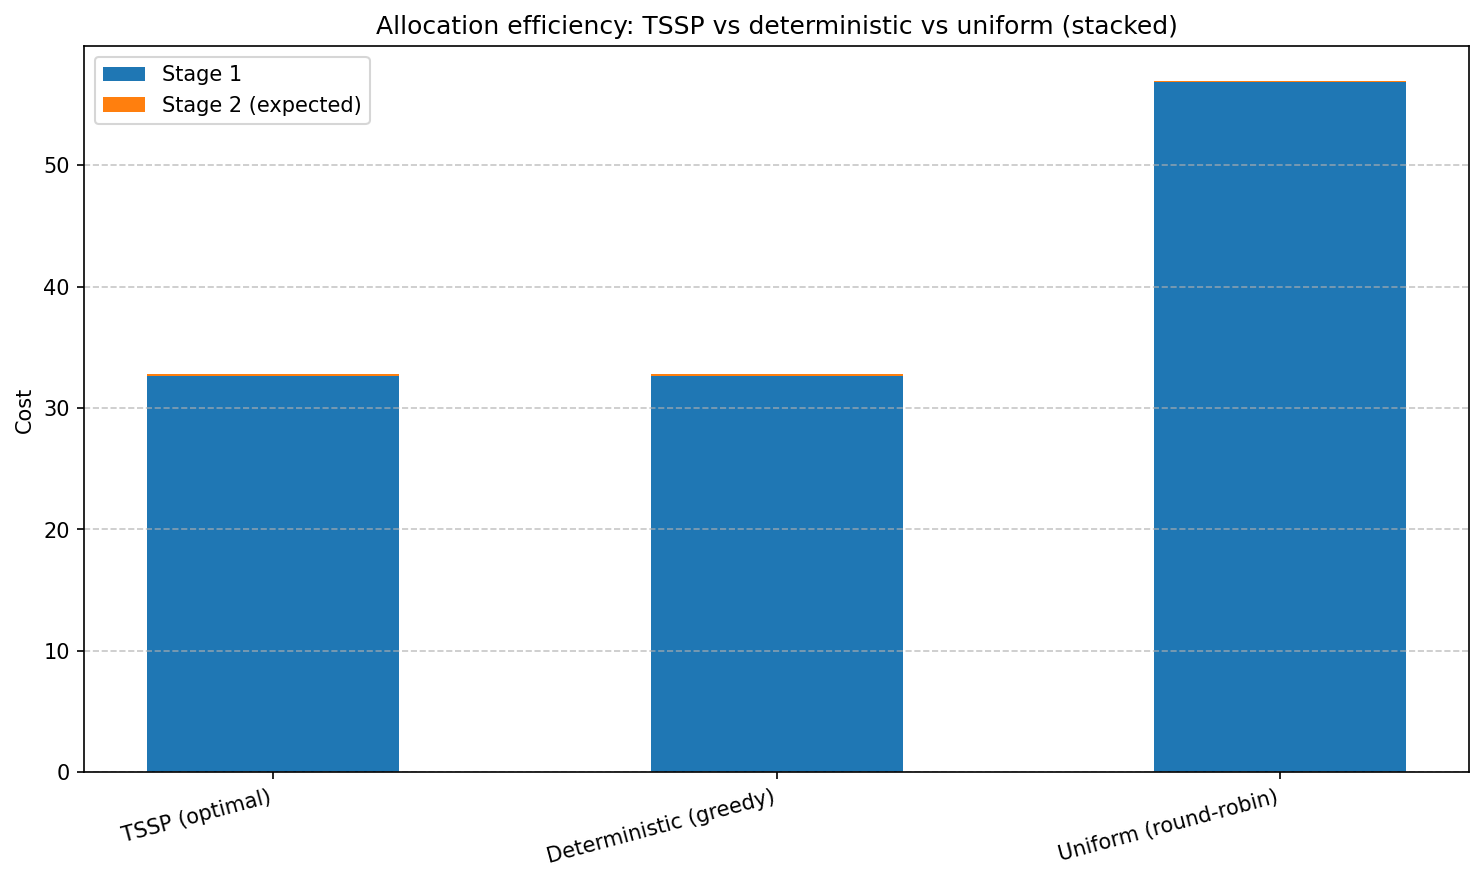

In [23]:
from IPython.display import display, Image
from src.analysis import evaluate_allocation_efficiency

alloc_result = evaluate_allocation_efficiency(
    tssp_model=tssp_model,
    tssp_inputs=tssp_inputs,
    output_dir=OUTPUT_DIR,
    solver_name="glpk",
)

# Comparison table
comparison_df = pd.DataFrame(alloc_result["comparison"])[
    ["method", "stage1_cost", "stage2_cost", "total_cost", "n_assignments", "success"]
]
display(comparison_df)

# Relative to TSSP optimal
print("\nRelative to TSSP optimal (total cost):")
if not np.isnan(alloc_result["deterministic_vs_optimal_pct"]):
    print(f"  Deterministic (greedy): +{alloc_result['deterministic_vs_optimal_pct']:.1f}%")
if not np.isnan(alloc_result["uniform_vs_optimal_pct"]):
    print(f"  Uniform (round-robin):  +{alloc_result['uniform_vs_optimal_pct']:.1f}%")
if alloc_result.get("plot_path") and Path(alloc_result["plot_path"]).exists():
    display(Image(filename=str(alloc_result["plot_path"])))

## 8. (Optional) Run Full Pipeline in One Go

In [24]:
from src.pipeline import MLTSSPPipeline

data_path = PROJECT_ROOT / "humint_source_dataset_15000_enhanced.csv"
pipeline = MLTSSPPipeline(data_path=data_path if data_path.exists() else None, random_seed=42)
results = pipeline.run_full_pipeline(
    n_sources=15000,
    opt_n_sources=100,
    opt_n_tasks=10,
    train_ml=True,
    solver_name="glpk",
)
print("Results keys:", list(results.keys()))
if "tssp" in results:
    print("TSSP solved:", results["tssp"].get("solved"))
if "analysis" in results:
    print("Analysis keys:", list(results["analysis"].keys()))


HUMINT ML-TSSP PIPELINE
Loading dataset from: D:\Updated-FINAL DASH\humint_source_dataset_15000_enhanced.csv
Dataset loaded: 15000 sources

TRAINING CLASSIFICATION MODEL


Applying SMOTE for class imbalance...



Training XGBoost Classifier (best performing model)...


XGBoost Accuracy: 0.9950
XGBoost F1-Score: 0.9950
XGBoost Precision: 0.9951
XGBoost Recall: 0.9950
Label encoder saved to: D:\Updated-FINAL DASH\models\classification_model_label_encoder.pkl
Model saved to: D:\Updated-FINAL DASH\models\classification_model.pkl

TRAINING REGRESSION MODELS

Training Reliability Score Model with GRU (best performing model)...


Reliability GRU R²: 0.9539
Reliability GRU RMSE: 0.0233
Reliability GRU MAE: 0.0187
Model saved to: D:\Updated-FINAL DASH\models\reliability_model.keras

Training Deception Score Model with GRU (best performing model)...


Deception GRU R²: 0.6382
Deception GRU RMSE: 0.1378
Deception GRU MAE: 0.1110
Model saved to: D:\Updated-FINAL DASH\models\deception_model.keras

PREPARING TSSP INPUTS
Generating behavior probabilities P(b | s) from XGBoost Classifier...
Generating reliability and deception scores from GRU models...


Calculating Stage 1 costs using ML predictions...
Calculating information values using ML predictions...

Summary of ML predictions used in TSSP:
  - Behavior probabilities: XGBoost Classifier
  - Reliability scores: GRU Regressor (mean: 0.461)
  - Deception scores: GRU Regressor (mean: 0.367)
Prepared inputs for 100 sources and 10 tasks

SOLVING TSSP OPTIMIZATION MODEL


Model built with 100 sources, 10 tasks, 4 behavior classes



✓ Optimization solved successfully!
  Optimal Objective Value: 32.92
  Number of assignments: 10

ANALYZING RESULTS


D:\Updated-FINAL DASH\src\analysis\cost_analysis.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=behavior_classes, y=costs, palette='viridis')


Saved plot to: D:\Updated-FINAL DASH\output\cost_by_behavior.png


D:\Updated-FINAL DASH\src\analysis\cost_analysis.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sources, y=costs, palette='viridis')


Saved plot to: D:\Updated-FINAL DASH\output\cost_by_source.png


Saved plot to: D:\Updated-FINAL DASH\output\cost_pie_chart.png
Report saved to: D:\Updated-FINAL DASH\output\cost_analysis_report.txt

TSSP COST ANALYSIS REPORT

COST VERIFICATION:
  Optimal Objective Value: 32.92
  Calculated Total Cost: 32.92
  Difference: 0.000000
  Verified: ✓

COST DECOMPOSITION:
  Stage 1 Cost (Strategic Tasking): 32.77
  Stage 2 Expected Recourse Cost: 0.15
  Total Expected Cost: 32.92
  Stage 2 Proportion: 0.45%

STAGE 2 COST BY BEHAVIOR CLASS:
  deceptive      :       0.10 (67.7%)
  coerced        :       0.04 (28.1%)
  uncertain      :       0.01 ( 4.2%)
  cooperative    :       0.00 ( 0.0%)

TOP 10 SOURCES BY STAGE 2 COST:
  SRC_00054      :       0.04
  SRC_00012      :       0.02
  SRC_00013      :       0.02
  SRC_00063      :       0.02
  SRC_00034      :       0.01
  SRC_00071      :       0.01
  SRC_00035      :       0.01
  SRC_00087      :       0.01
  SRC_00052      :       0.01
  SRC_00070      :       0.01


CALCULATING ADVANCED METRICS

PREPARING

Calculating Stage 1 costs using ML predictions...
Calculating information values using ML predictions...

Summary of ML predictions used in TSSP:
  - Behavior probabilities: XGBoost Classifier
  - Reliability scores: GRU Regressor (mean: 0.461)
  - Deception scores: GRU Regressor (mean: 0.367)
Prepared inputs for 100 sources and 10 tasks

Calculating Expected Value of Perfect Information (EVPI)...
  Calculating wait-and-see value for 4 scenarios...


  EVPI: -98.66
  EVPI Percentage: -299.72%

Calculating Expected Mission Value (EMV)...
  EMV: -26.56
  Information Value: 6.36

Performing Sensitivity Analysis...
Performing sensitivity analysis on recourse costs...


Performing sensitivity analysis on behavior probabilities...


Performing sensitivity analysis on Stage 1 costs...


Saved sensitivity plot to: D:\Updated-FINAL DASH\output\sensitivity_recourse_costs.png


Saved sensitivity plot to: D:\Updated-FINAL DASH\output\sensitivity_behavior_probs.png
  Sensitivity analysis completed

Calculating Efficiency Frontier...
Calculating efficiency frontier with 20 allocation scenarios...


Efficiency frontier calculated: 9 frontier points, 11 dominated points
  Efficiency frontier calculated: 9 frontier points


Efficiency frontier plot saved to: D:\Updated-FINAL DASH\output\efficiency_frontier.png
Advanced metrics report saved to: D:\Updated-FINAL DASH\output\advanced_metrics_report.txt

ADVANCED METRICS REPORT

EXPECTED VALUE OF PERFECT INFORMATION (EVPI):
  Current Value (Here-and-Now): 32.92
  Wait-and-See Value (Perfect Info): 131.58
  EVPI: -98.66
  EVPI Percentage: -299.72%
  Interpretation: EVPI = -98.66 means we would save up to -98.66 units (-299.7%) with perfect information about behaviors.

EXPECTED MISSION VALUE (EMV):
  Total Cost: 32.92
  Stage 1 Cost: 32.77
  Stage 2 Cost: 0.15
  Information Value: 6.36
  EMV (Net Mission Value): -26.56
  EMV per Source: -2.66
  Interpretation: EMV = -26.56 represents the net mission value (Information Value: 6.36 - Total Cost: 32.92).

SENSITIVITY ANALYSIS:
  Baseline Objective Value: 32.92

  Recourse Cost Sensitivity:
    deceptive      : Range = 0.04 (Min: 32.90, Max: 32.94)
    coerced        : Range = 0.02 (Min: 32.91, Max: 32.93)
    unc